In [53]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg

In [2]:
def read_log():
    f = open('./logs/log.txt', 'r')
    lines = f.readlines()
    f.close()
    
    #eps, gamma, lr, step_reward, reward, moves, traps, energy, time
    lines = list( map(lambda x: x.strip().split(), lines) )
    lines = list( map(lambda x: list(map(float, x) ), lines) )
    cnt = len(lines)
    lines = [x for x in lines if len(x)==len(lines[1])]
    cnt -= len(lines)
    
    df = pl.DataFrame(lines,
                      schema = {"eps":pl.Float32, "gamma":pl.Float32,
                                "lr":pl.Float32, "step_reward":pl.Float32,
                                "reward":pl.Float32, "moves":pl.Int32,
                                "traps":pl.Int32, "energy":pl.Int32,
                                "time":pl.Float32})
    
    print(f"found {cnt} invalid lines ")
    
    return df
    
    

In [3]:
#custom format
def c_f(d,k):
    if k == 'eps':
        return f"{d[k][0]:.3e}"
    elif k == 'gamma':
        return f"{d[k][0]:.3e}"
    elif k == 'lr':
        return f"{d[k][0]:.3e}"
    elif k == 'step_reward':
        return f"{d[k][0]:.1f}"
        

In [4]:
def plot_resultVShp(df, hp, ix):

    hps = ["eps", "gamma", "lr", "step_reward"]
    
    df = df.group_by(
    [x for x in hps if x != hp]).agg(
        pl.col(hp), pl.col("reward"), pl.col("moves"), pl.col("traps"), pl.col("energy"), pl.col("time") )

    if ix is None:
        ix = np.random.randint(0,df.shape[0])
    
    data = df[ix,]
    d = data[ : , :3 ].to_dict()
    
    title = f"ix: {ix} | " + " | ".join([ f"{k} : {c_f(d,k)}" for k in d.keys()])
    
    
    for y in ["reward", "moves", "traps", "energy", "time"]:
        fig = plt.figure(figsize=(7,5))
        ax = fig.subplots(1,1)
        ax.set_xlabel(hp)
        ax.set_ylabel(y)
        ax.set_title(title)
        ax.plot(data[hp][0], data[y][0], c='blue', marker='*', mfc='red', mec='red')

    
    

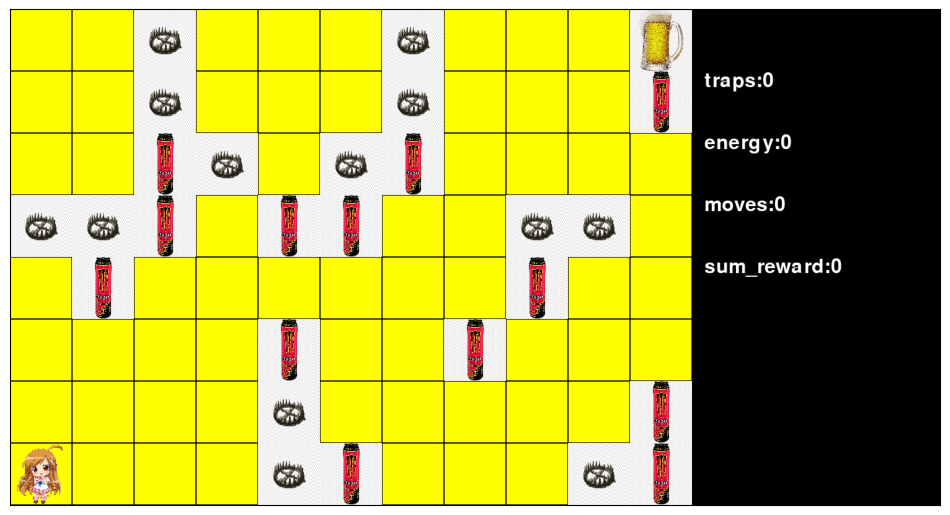

In [66]:
fig = plt.Figure(figsize=(12,10))
ax = fig.subplots(1,1)
ax.imshow(mpimg.imread('./game_map.png'))
ax.set_xticks([])
ax.set_yticks([])
fig

# Вот так выглядит начальное состояние среды

## Параметры среды:
 $max\_iter = 2000$ \
 $trap\_reward = -200$ \
 $energy\_reward = 50$ \
 $fin\_reward = 200$ 

## Правила игры таковы:
## 1. Нужно максимизировать награду за эпизод 
## 2. В случае если агент попадает в правый верхний угол быстрее чем за $max\_iter$ шагов, он получает бонус в размере $fin\_reward$ и эпизод завершается
## 3. После $max\_iter$ шагов эпизод завершается
## 4. При попадании на клетку с энергетиком агент получает бонус в размере $energy\_reward$ и энергетик исчезает
## 5. При попадании на клетку с ловушкой агент получает штраф в размере $|trap\_reward|$ и ловушка исчезает
## 6. При попадании на пустую клетку или при попытке "пойти в стену" агент получает штраф в размере $|step\_reward|$ ($step\_reward$ не является параметром среды, а является параметром самого алгоритма обучения как, например, $learning\_rate$)
## 7. Агент может двигаться на одну клетку по горизонтали или по вертикали


In [5]:
df = read_log()

found 135 invalid lines 


/usr/lib/python3.10/functools.py:889: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return dispatch(args[0].__class__)(*args, **kw)


In [6]:
df.describe()

statistic,eps,gamma,lr,step_reward,reward,moves,traps,energy,time
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",59696.0,59696.0,59696.0,59696.0,59696.0,59696.0,59696.0,59696.0,59696.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.099885,0.547708,0.503903,-10.539361,390.985687,31.748559,0.003886,7.242914,0.758055
"""std""",0.06069,0.271937,0.305433,6.052154,134.401474,29.06779,0.072422,1.708845,0.53461
"""min""",0.0001,0.1,0.01,-20.0,-2383.0,17.0,0.0,2.0,0.240375
"""25%""",0.042184,0.289474,0.222143,-15.777778,313.333344,19.0,0.0,6.0,0.350857
"""50%""",0.094789,0.526316,0.505,-11.555555,384.444458,23.0,0.0,7.0,0.519582
"""75%""",0.147395,0.763158,0.787857,-5.222222,470.222229,31.0,0.0,8.0,1.149632
"""max""",0.2,1.0,1.0,-1.0,820.0,2000.0,6.0,15.0,13.055387


# В среднем был сделан 31 ход, собрано 7 энергетиков и зарегистрировано 0 попаданий в ловушки

# Теперь порисуем графики.
## Они будут строиться согласно следующей схеме:

$hps :=$ ["eps", "gamma", "lr", "step_reward"] \
фиксируем один гиперпараметр $hp \in hps$ \
после этого фиксируем конкретные значения всех гиперпараметров из $hps \setminus hp$\
из логов выбираем все строки, в которых значения гиперпараметров из $hps \setminus hp$ равны заданным\
теперь, перебирая все возможные значения $hp$ строим графики по типу $reward$ VS $hp$, $time$ VS $hp$ итд 

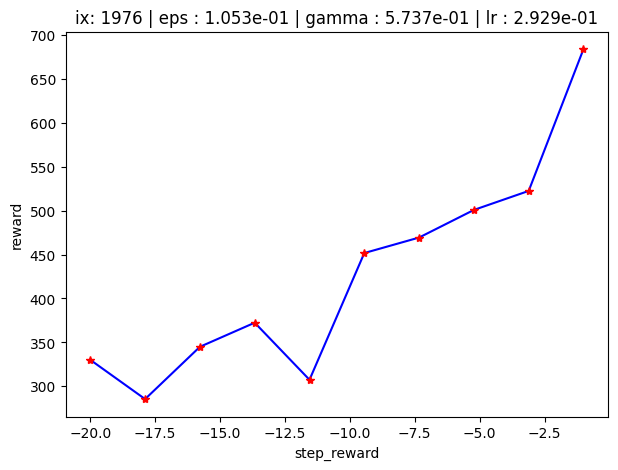

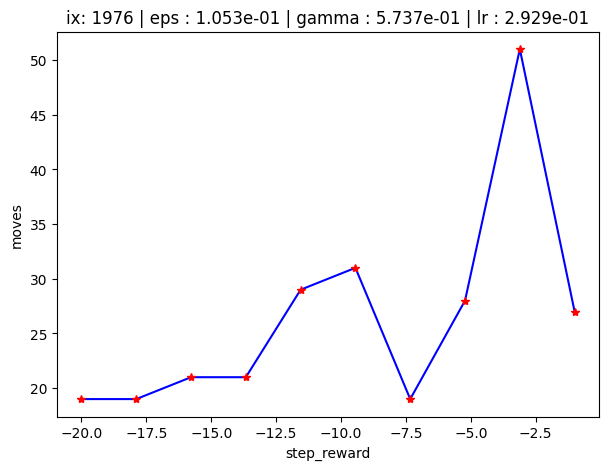

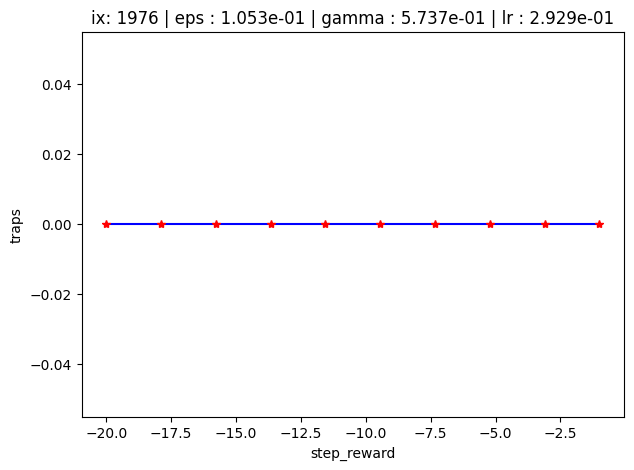

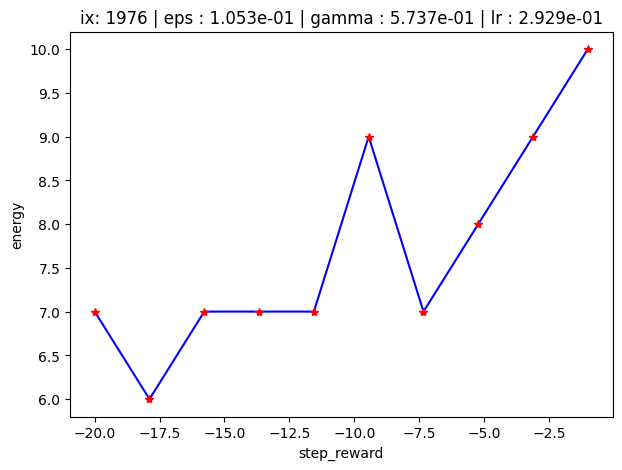

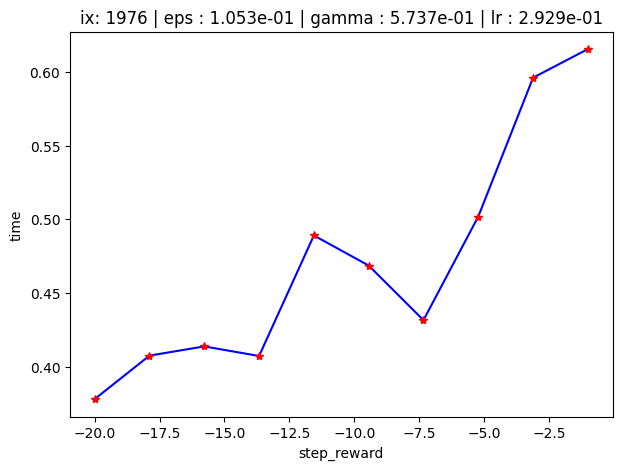

In [28]:
plot_resultVShp(df, "step_reward", None) #736

# В данном примере мы наблюдаем следующее:
## С уменьшением штрафа за шаг суммарная награда увеличивалась ( если предположить, что агент принимал примерно одинаковые решения при различных step_reward, то всё выглядит разумно - с уменьшением суммарного штрафа увеличивалась суммарная награда)
## С уменьшением штрафа за шаг увеличивалось кол-во ходов (можно предположить, что с уменьшением штрафа у агента появилась возможность увеличить суммарную награду засчёт собирания энергетиков, которые до этого собирать было невыгодно ввиду их местоположения)
## График energy VS step_reward как будто бы подтверждает высказанную выше гипотезу
## И, наконец, с уменьшением штрафа за шаг суммарное время прохождения эпизода увеличивалось (ожидаемо)  

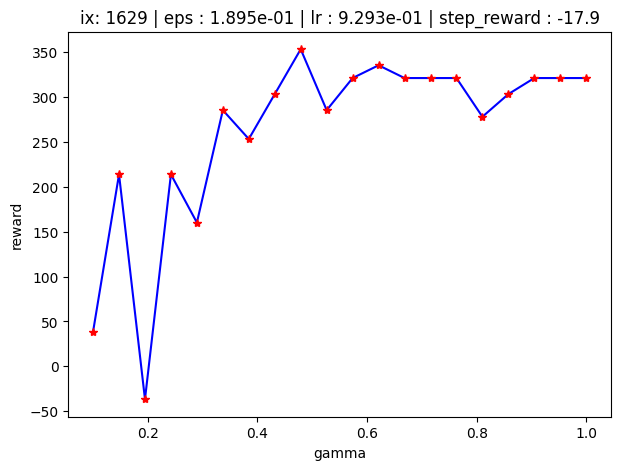

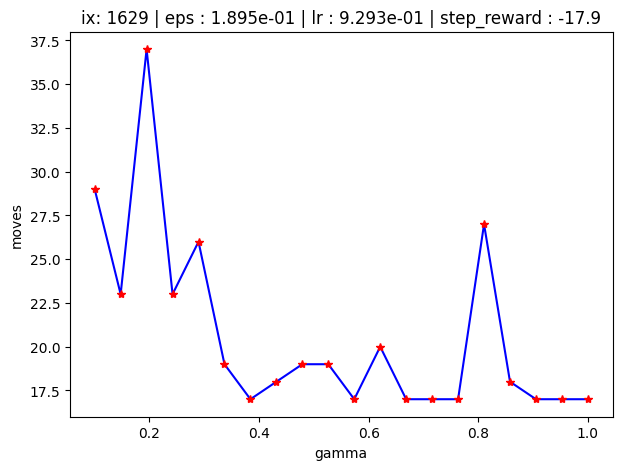

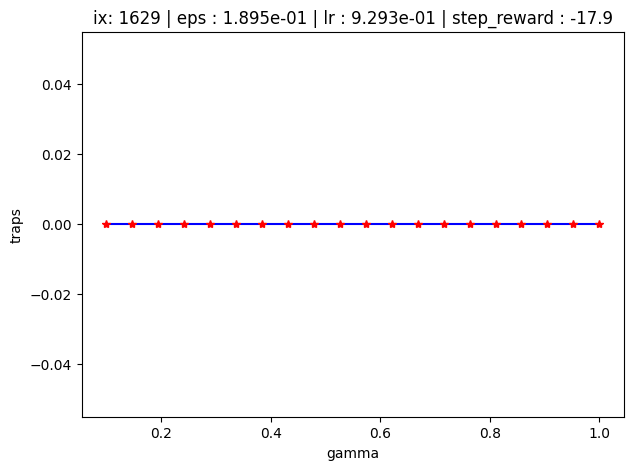

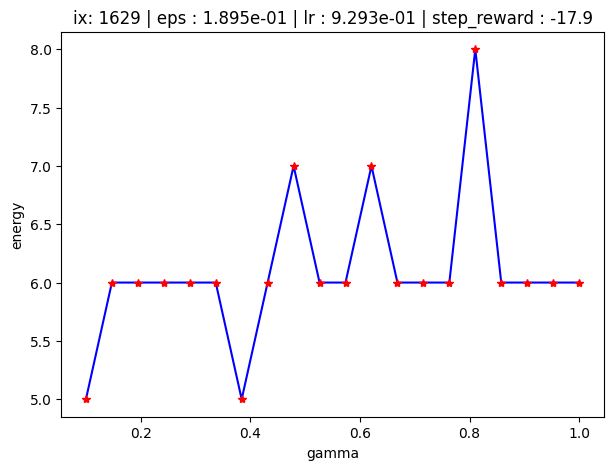

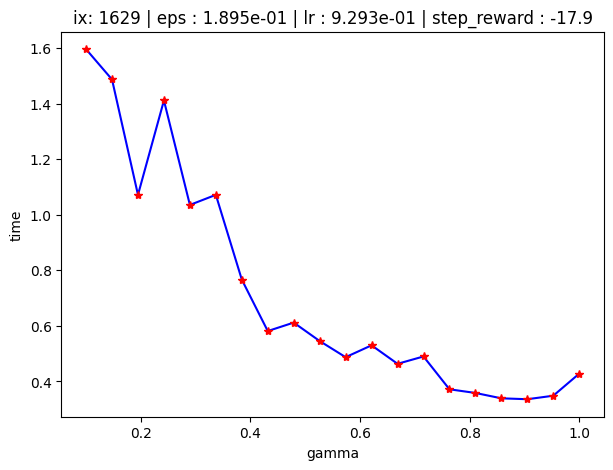

In [30]:
plot_resultVShp(df, "gamma", None)

# Параметр gamma является коэффициентом дисконтирвания. Его можно воспринимать как меру того, насколько сильно агент предпочитает получать выгоду в будущем нежели в настоящем.

## С увеличением gamma возрастала суммарная награда (при маленьких значениях агент может сделать локально оптимальный выбор который сильно хуже глобально оптимального)

## С возрастанием gamma уменьшалось число ходов (можно предположить, что агент переставал делать локально оптимальные выборы, которые, например, могли завести его в левый верхний угол карты сильно удалённый от цели)

## Количество собранных энергетиков колеблется около среднего

## С уменьшением интереса к способам "быстрой наживы", которые могут быть довольно долгими, уменьшалось и суммарное время

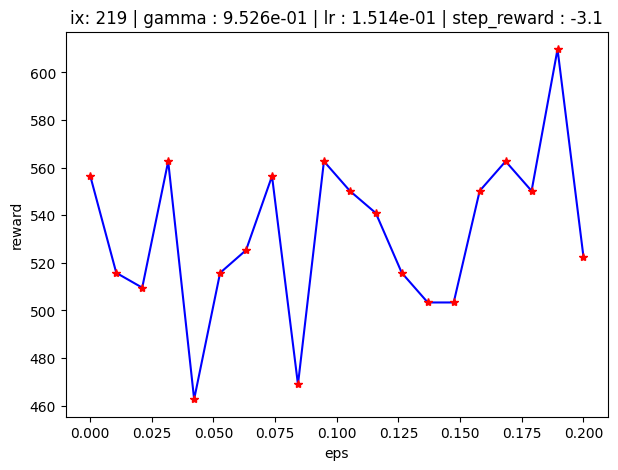

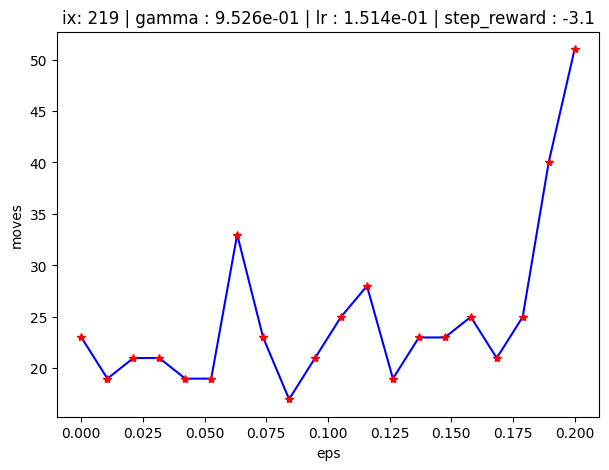

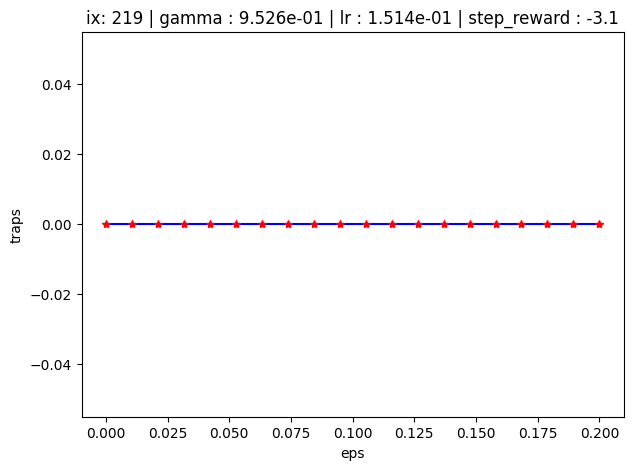

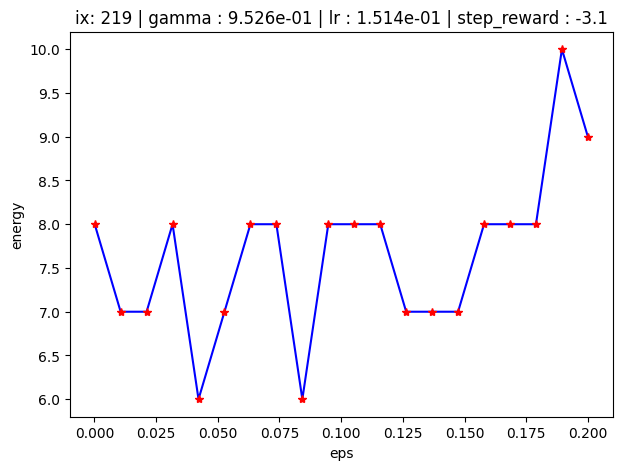

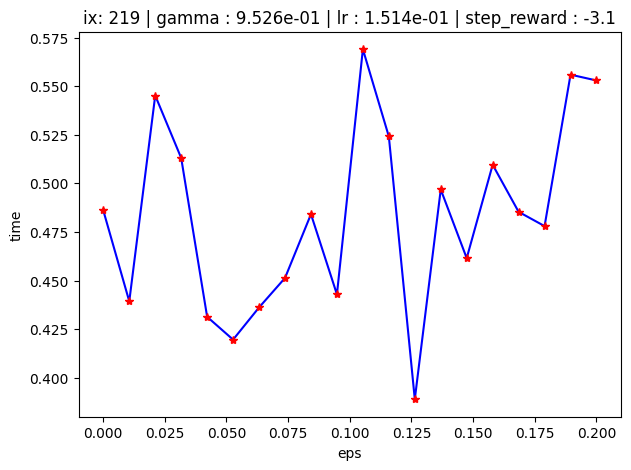

In [67]:
plot_resultVShp(df, "eps", None)

# Параметр eps отвечал за вероятность того, что действие будет выбрано случайно, а не на основе накопленного опыта
## График reward выглядит непрезентабельно, не хотелось бы пытаться его интерпретировать
## А вот на втором графике ситуация лучше - видно, что до определённого момента всё было стабильно, но, после определённого порога, количество ходов начало увеличиваться (т.к. слишком часто выбиралось случайное действие, что мешало агенту)
## Количество энергетиков сначала колеблется в диапазоне от 7 до 8, а в конце увеличивается до 9 и 10 засчёт большого кол-ва случайных действий
## При использованных значениях eps график time получился не сильно информативным. Но, легко понять, что при eps >= 0.8 можно считать, что решения принимаются случайно и никакого обучения не происходит (и время сильно увеличится относительно того что было при малых eps)

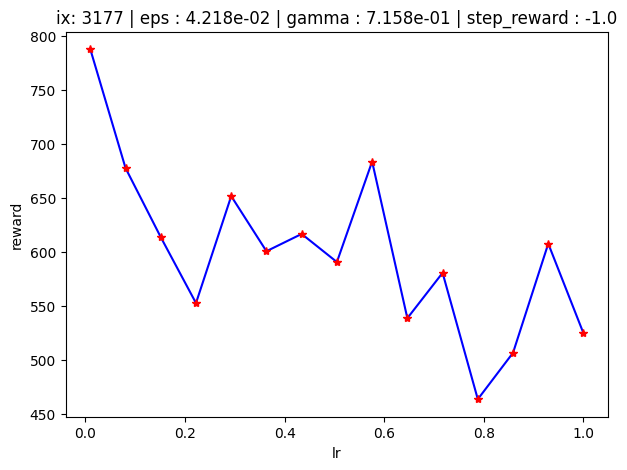

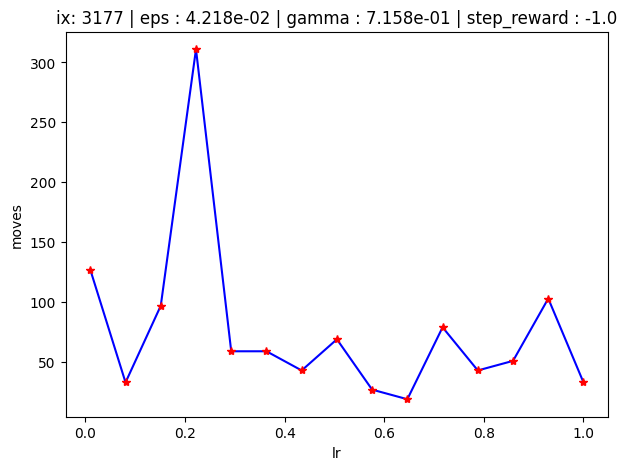

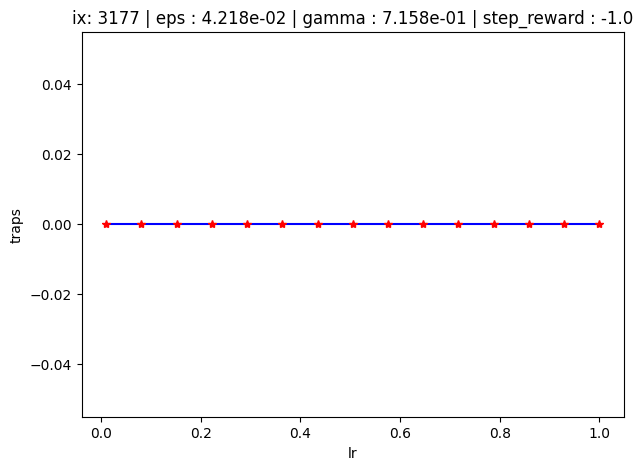

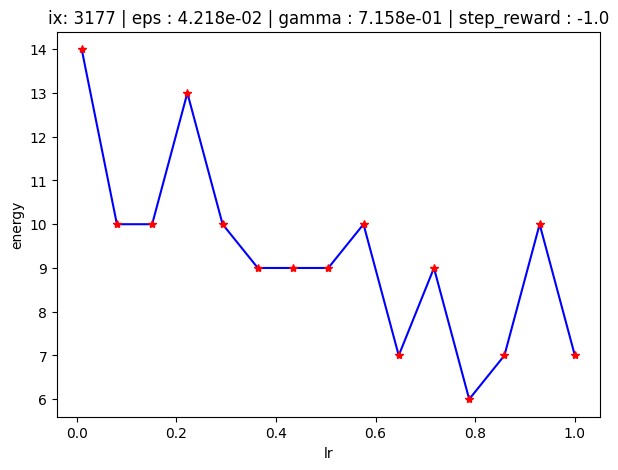

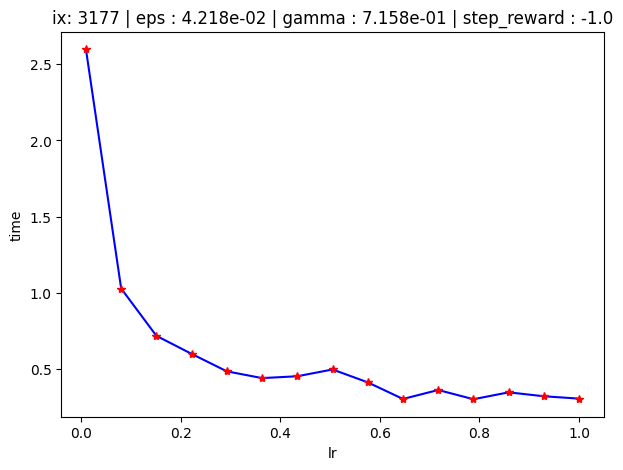

In [70]:
plot_resultVShp(df, "lr", None)

## При малой скорости обучения награда была довольно высокой, а при lr > 0.3 происходили флуктуации около значения 600 
## Количество ходов оставалось примерно одинаковым за исключением lr=0.2
## При lr <= 0.3 было собрано довольно много энергетиков, этим можно объяснить вид графика reward VS lr
## Ожидаемо, с увеличением lr уменьшалось суммарное время. Агент быстрее понимал, что бегать где-то в окрестности старта или собирать энергетики по углам - не лучшая идея